# Hasnain 2023

In [1]:
# Classic python
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from copy import deepcopy
import copy
import os
import sys
from importlib import reload
import textwrap
import random
import pickle

from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/jpic/bioObsv/scr')
sys.path.append('/home/jpic/bioObsv/')

from src import bioObsv
from src.dataPrep import *
from src.visualization import *
from src.estimation import *
reload(bioObsv.Model)
reload(bioObsv.estimation)

from nb_util import *

## Load Data

In [2]:
datapath = '/nfs/turbo/umms-indikar/shared/projects/public_data/time_series_RNA/hasnain/data.pkl'
with open(datapath, 'rb') as f:
    # Load the object from the file
    hasnain = pickle.load(f)
print(f"{hasnain.keys()=}")

Xtest = hasnain['FC']
print(f"{Xtest.shape=}")

numSensors  = np.arange(10, 351, 10)
print(f"{numSensors=}")


hasnain.keys()=dict_keys(['FC', 'genes'])
Xtest.shape=(624, 9, 2)
numSensors=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350])


## Perform Biomarker Selection and Estimation

In [3]:
models      = ['Fixed', 'Dynamic']
predTimes = [7]
res1 = {
    'model'     :[],
    'numSensors':[],
    'method'    :[],
    'replicate' :[],
    'Norm'      :[],
    'MSE'       :[],
    'mean % error':[],
    'median % error':[]
}
res2 = {
    'state'    :[],
    'nSensors' :[],
    '% error'  :[],
    'method'   :[],
    'replicate':[],
    'model'     :[]
}
# DMD v DGC
for model in models:
    print(model)
    Xtest = hasnain['FC']
    x0    = Xtest[:,0,:]
    # X     = hasnain['FC']
    X = np.mean(hasnain['FC'], axis=2)
    if model == 'Fixed':
        LTV = bioObsv.Model.LinearTimeVariant(data=X, times=[0, 9], dmdRanks=[-1], states=list(np.arange(1,X.shape[0]+1)))
        t0, t1 = 0, 9
        for t0p in range(t0+1, t1):
            LTV.LTI[t0p] = bioObsv.Model.LinearTimeInvariant(states=list(np.arange(1,X.shape[0]+1)))
            LTV.LTI[t0p].dmd_res['Atilde'] = LTV.LTI[t0].dmd_res['Atilde']
            LTV.LTI[t0p].dmd_res['u_r'] = LTV.LTI[t0].dmd_res['u_r']
            LTV.LTI[t0p].f = {}
            LTV.LTI[t0p].f['A'] = LTV.LTI[t0].f['A']
        # fixed sensor seleciton
        sensorEnergySelectionTimes = np.arange(X.shape[1])
        TVSensors = bioObsv.sensorSelection.obsvEnergyMaximization(LTV)
        organizeEnergySensors = {}
        organizeEnergySensors[0] = TVSensors['sensors']['state'].values
        sdf = pd.DataFrame(organizeEnergySensors)
    else:
        LTV = bioObsv.Model.LinearTimeVariant(data=X, times=None, dmdRanks=[-1], states=list(np.arange(1,X.shape[0]+1)))
        # dynamic sensor seleciton
        sensorEnergySelectionTimes = np.arange(X.shape[1])
        TVSensors = bioObsv.sensorSelection.energyMaximizationTV(LTV, sensorEnergySelectionTimes, v=False)
        organizeEnergySensors = {}
        for i in TVSensors.keys():
            organizeEnergySensors[i] = TVSensors[i]['sensors']['state'].values
        sdf = pd.DataFrame(organizeEnergySensors)
        
    # number of sensors
    for nSensors in numSensors:
        print(nSensors)
        sensors = {}
        for t in range(len(LTV.LTI)):
            if model == 'Dynamic':
                sensors[t] = list(sdf.iloc[:nSensors,t].values)
            else:
                sensors[t] = list(sdf.iloc[:nSensors].values)
        LTV.setMeasurments(sensors)
        for t in range(len(LTV.LTI)):
            LTV.LTI[t].output['C'] = LTV.LTI[t].output['C'].toarray()
        O = LTV.obsv(t=predTimes[0]+1, reduced=True)
        x0e = leastSquaresX0new(LTV, Xtest, v=False, O=O, times=predTimes)
        x0e = x0e[:,predTimes[0],:]
        for r in range(x0.shape[1]):
            e = np.linalg.norm(x0[:,r] - x0e[:,r])
            mse = mean_squared_error(x0[:,r], x0e[:,r])
            percent_change = abs((((x0[:,r]+1) - (x0e[:,r]+1)) / (x0[:,r]+1)) * 100)
            res1['numSensors'].append(nSensors)
            res1['model'].append(model)
            res1['method'].append('Energy')
            res1['replicate'].append(r)
            res1['Norm'].append(e)
            res1['MSE'].append(mse)
            res1['mean % error'].append(np.mean(percent_change))
            res1['median % error'].append(np.median(percent_change))
            for i in range(len(percent_change)):
                res2['model'].append(model)
                res2['state'].append(i)
                res2['% error'].append(percent_change[i])
                res2['method'].append('Energy')
                res2['replicate'].append(r)
                res2['nSensors'].append(nSensors)
                
rdf1 = pd.DataFrame(res1)
rdf2 = pd.DataFrame(res2)
rdf1.to_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_oct26.csv')
rdf2.to_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_oct26.csv')

Fixed
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
(624, 1)
10
20


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


30


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


40


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


50


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


60


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


70


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


80


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


90


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


100


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


110


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


120


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


130


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


140


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


150


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


160


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


170


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


180


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


190


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


200


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


210


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


220


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


230


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


240


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


250


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


260


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


270


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


280


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


290


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


300


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


310


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


320


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


330


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


340


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


350


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


Dynamic
10
20


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


30
40
50
60


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


70


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


80


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


90


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


100


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


110


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


120


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


130


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


140


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


150


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


160


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


170


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


180


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


190


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


200


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


210


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


220


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


230


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


240


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


250


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


260


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


270


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


280


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


290


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


300


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


310


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


320


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


330


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


340


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


350


 /home/jpic/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


## Load Resulting Data

In [4]:
rdf1 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res1.csv')
rdf2 = pd.read_csv('/nfs/turbo/umms-indikar/Joshua/obsvArticle/results/hasnain_estimation_fixed_v_dynamic_res2.csv')
rdf1

,Unnamed: 0,model,numSensors,method,replicate,Norm,MSE,mean % error,median % error
0,0,Fixed,1,Energy,0,57.269469,5.256077,705.037388,161.733671
1,1,Fixed,1,Energy,1,33.839012,1.835062,364.585892,77.691202
2,2,Fixed,11,Energy,0,26.307161,1.109081,232.395271,64.620911
3,3,Fixed,11,Energy,1,22.487582,0.810403,211.439596,48.762993
4,4,Fixed,21,Energy,0,23.947894,0.919073,203.747169,61.212215
...,...,...,...,...,...,...,...,...,...
247,247,Dynamic,601,Energy,1,19.948771,0.637746,171.914256,51.643309
248,248,Dynamic,611,Energy,0,19.941741,0.637297,194.453469,48.260261
249,249,Dynamic,611,Energy,1,19.941741,0.637297,171.891911,51.738956
250,250,Dynamic,621,Energy,0,19.954023,0.638082,194.343178,48.701135


## Visualize

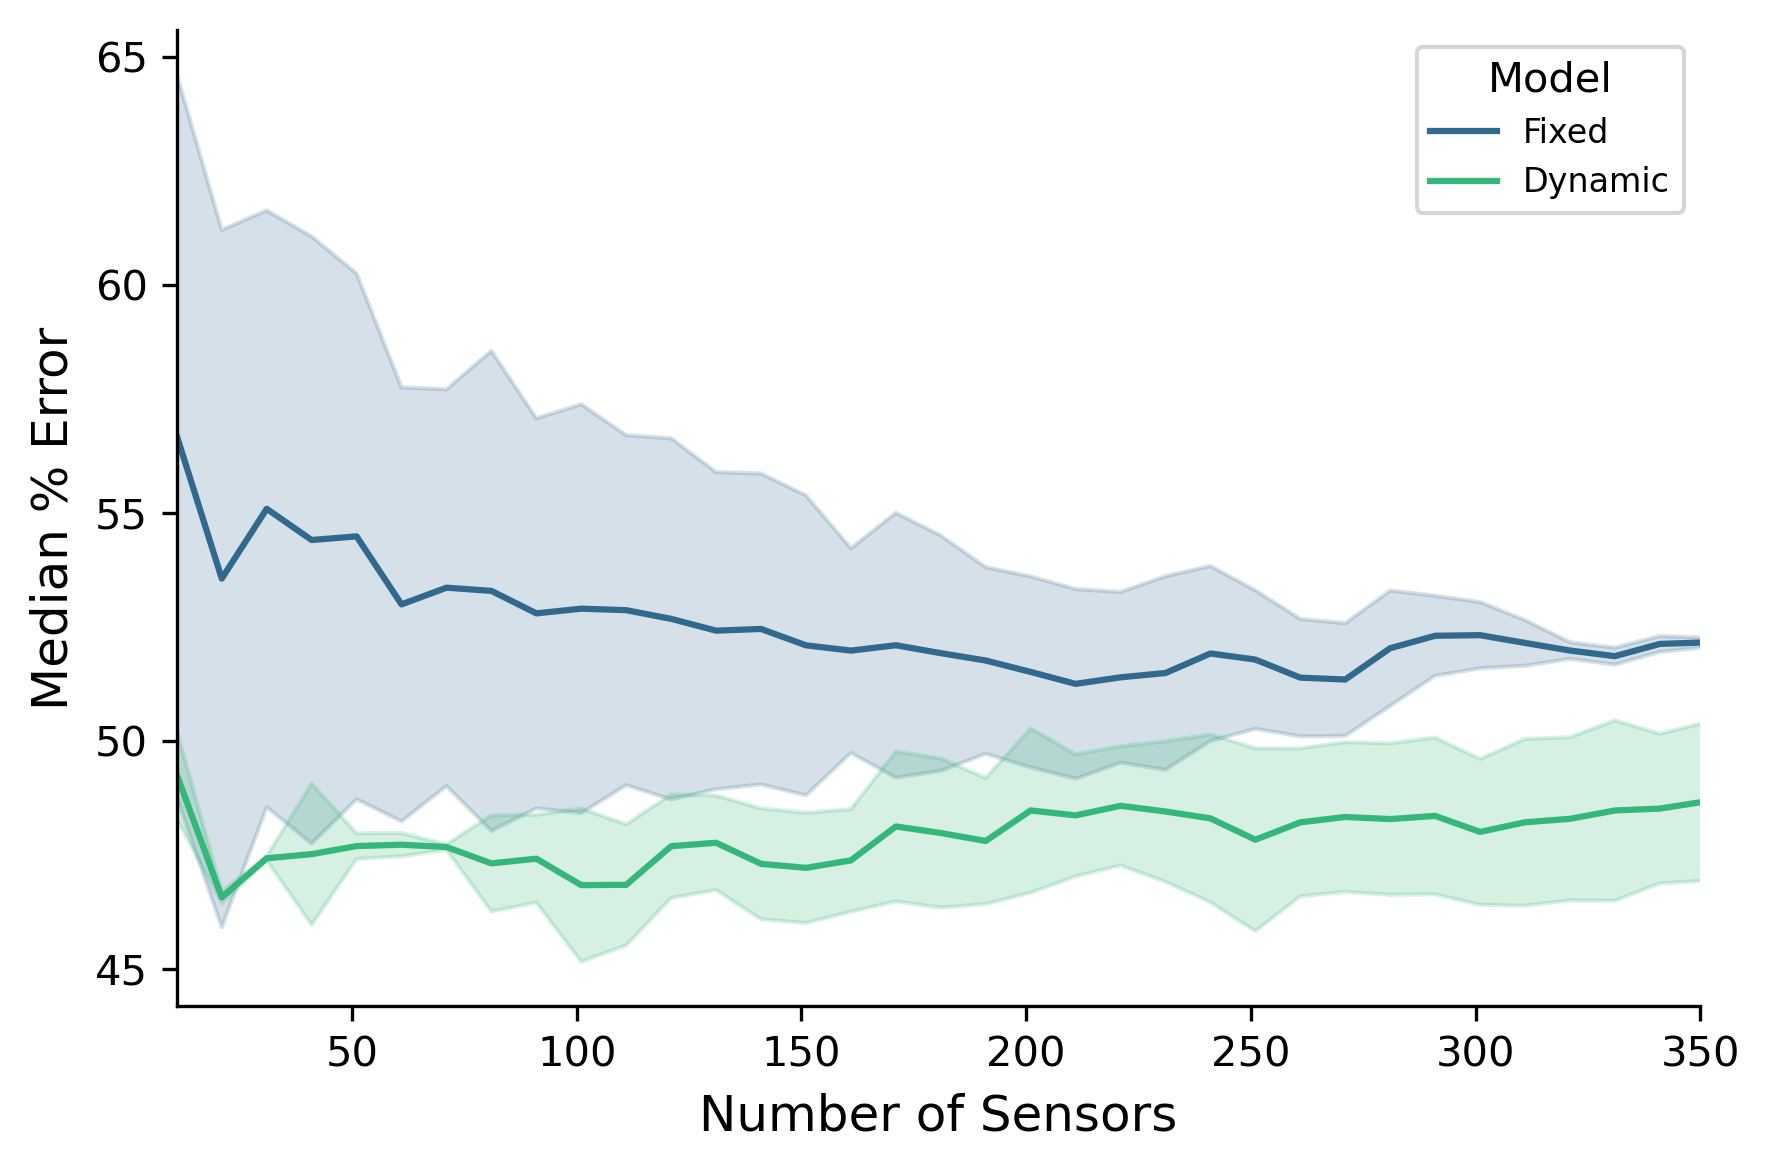

In [5]:
plt.figure(figsize=(6, 4), dpi=300)
pdf = rdf1[rdf1['numSensors'] > 1]
# Adjust marker size and color palette
sns.lineplot(data=pdf,
                x='numSensors',
                y='median % error',
                hue='model',
                palette='viridis')
plt.xlabel('Number of Sensors', fontsize=12)
plt.ylabel('Median % Error', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model', fontsize=8)
# plt.grid(True)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xlim(11, 350)
plt.tight_layout()
sns.despine()
plt.show()